In [1]:
cd ..

d:\research\fedmiss_bench


In [2]:
%load_ext autoreload
%autoreload 2
%load_ext dotenv
%dotenv
import pandas as pd
from src.loaders.load_data import load_data
from collections import OrderedDict
import numpy as np

In [3]:
from sklearn.preprocessing import KBinsDiscretizer
X = np.random.choice([0, 1], size=(100, 1))
est = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform', subsample = None)
est.fit_transform(X)

array([[9.],
       [9.],
       [9.],
       [9.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [9.],
       [0.],
       [0.],
       [0.],
       [9.],
       [0.],
       [0.],
       [0.],
       [9.],
       [0.],
       [9.],
       [0.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [9.],
       [0.],
       [0.],
       [9.],
       [9.],
       [9.],
       [9.],
       [0.],
       [0.],
       [9.],
       [0.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [9.],
       [0.],
       [0.],
       [0.],
       [9.],
       [0.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [9.],
       [9.],
       [0.],
       [0.],
       [0.],
       [0.],
       [9.],
       [9.],
       [0.],
       [9.],
       [0.],
       [9.],
       [9.],
       [0.],
       [9.],
       [9.],
       [9.],
       [0.],

## Functions

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

def show_heatmap(df, figsize=(8, 6)):
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(), annot=True, fmt=".1f")
    plt.show()

In [5]:
def avg_correlation(df):
    avg_correlation_cols = list(OrderedDict(df.corr().abs().mean().sort_values(ascending=False).to_dict()).items())
    features = set(df.columns.tolist()[:-1])
    avg_correlation_cols = [col for col in avg_correlation_cols if col[0] in features]
    return avg_correlation_cols

In [6]:
from sklearn.cluster import KMeans
def kbins(data, data_config):

    est = KMeans(n_clusters=10, random_state=0)

    X = data.iloc[:, data_config['split_col_idx']].values
    X = est.fit_predict(X)
    
    return X

## Codrna

In [7]:
df, data_config = load_data('codrna')
show_heatmap(df,  figsize = (6,4))
print(avg_correlation(df))
print(data_config)

In [38]:
avg_cols = avg_correlation(df)
avg_cols = [col[0] for col in avg_cols]
split_col_idx = [df.columns.tolist().index(col) for col in avg_cols]
split_col_idx

In [63]:
cl = kbins(df, data_config)
np.unique(cl, return_counts=True)

In [41]:
data_config

## HHP

In [95]:

############################################################################################################
# Load data
# members
df_members = pd.read_csv('./data/HHP_herritage_health/Members.csv')
df_members['Sex'] = df_members['Sex'].map({'M': 1, 'F': 0})
df_members['AgeAtFirstClaim'] = df_members['AgeAtFirstClaim'].map({
    '0-9': 5,
    '10-19': 15,
    '20-29': 25,
    '30-39': 35,
    '40-49': 45,
    '50-59': 55,
    '60-69': 65,
    '70-79': 75,
    '80+': 90
})

# drug and lab
df_drug = pd.read_csv('./data/HHP_herritage_health/DrugCount.csv')
df_drug['DrugCount'] = df_drug['DrugCount'].map({'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7+': 10})
df_lab = pd.read_csv('./data/HHP_herritage_health/LabCount.csv')
df_lab['LabCount'] = df_lab['LabCount'].map(
    {'1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10+': 12}
)

# days
df_days_y2 = pd.read_csv('./data/HHP_herritage_health/DaysInHospital_Y2.csv')
df_days_y2['Year'] = 'Y1'
df_days_y3 = pd.read_csv('./data/HHP_herritage_health/DaysInHospital_Y3.csv')
df_days_y3['Year'] = 'Y2'

df_days = pd.concat([df_days_y2, df_days_y3])

df_claims = pd.read_csv('./data/HHP_herritage_health/Claims.csv')

# divide by provider
# providers = df_claims['ProviderID'].value_counts().iloc[: 10].index.tolist()
# df_claims = df_claims[df_claims['ProviderID'].isin(providers)]
# print(df_claims.shape)

df_claims = pd.merge(df_claims, df_members, on='MemberID', how='left')
df_claims = pd.merge(df_claims, df_drug, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_lab, on=['MemberID', 'Year', 'DSFS'], how='left')
df_claims = pd.merge(df_claims, df_days, on=['MemberID', 'Year'], how='left')
df_claims = df_claims[df_claims['DaysInHospital'].notna()]
print(df_claims.shape)

#################################################################################################################
# Feature engineering
# drop missing age and sex
df_claims = df_claims[df_claims['AgeAtFirstClaim'].notna()].copy()
df_claims = df_claims[df_claims['Sex'].notna()].copy()
df_claims = df_claims[df_claims['DSFS'].notna()].copy()

# transform categorical columns
def transform1(row):
    if pd.isna(row):
        return 'None'
    else:
        return str(int(row))
    
df_claims['ProviderID'] = df_claims['ProviderID'].map(transform1)
df_claims['Vendor'] = df_claims['Vendor'].map(transform1)
df_claims['PCP'] = df_claims['PCP'].map(transform1)

# handle missing values for categorical columns
df_claims['ProcedureGroup'] = df_claims['ProcedureGroup'].fillna('None', inplace=False)
df_claims['Specialty'] = df_claims['Specialty'].fillna('None', inplace=False)
df_claims['PrimaryConditionGroup'] = df_claims['PrimaryConditionGroup'].fillna('None', inplace=False)
df_claims['PlaceSvc'] = df_claims['PlaceSvc'].fillna('None', inplace=False)

# encode number of columns
df_claims['CharlsonIndex'] = df_claims['CharlsonIndex'].map({'0': 0, '1-2': 1.5, '3-4': 3.5, '5+': 7})
df_claims['PayDelay'] = df_claims['PayDelay'].apply(lambda row: int(row) if row != '162+' else 200)
df_claims['LengthOfStay'] = df_claims['LengthOfStay'].map({
    '1 day': 1, '2 days': 2, '3 days': 3, '4 days': 4, '5 days': 5, '6 days': 6, '1- 2 weeks': 10, '2- 4 weeks': 21, '4- 8 weeks': 42,
})
df_claims['DSFS'] = df_claims['DSFS'].map({
    '0- 1 month': 1, '1- 2 months': 2, '2- 3 months': 3, '3- 4 months': 4, '4- 5 months': 5, '5- 6 months': 6, 
    '6- 7 months': 7, '7- 8 months': 8, '8- 9 months': 9, '9-10 months': 10, '10-11 months': 11, '11-12 months': 12
})

# filter all large claims
df_claims = df_claims[df_claims['DaysInHospital'] > 0].copy()
print(df_claims.shape)

# fill mean values for drug and lab counts
df_claims['DrugCount'] = df_claims['DrugCount'].fillna(df_claims['DrugCount'].mean(), inplace=False)
df_claims['LabCount'] = df_claims['LabCount'].fillna(df_claims['LabCount'].mean(), inplace=False)

# drop length of stay
df_claims = df_claims.drop(columns=['LengthOfStay'])

#########################################################################################################################
# Feature selection
# numerical features
def feature_agg(df, key):
    ret = df.groupby(['MemberID', 'Year']).agg(
        **{
            key+'_mean': pd.NamedAgg(column=key, aggfunc='mean'),
            key+'_std': pd.NamedAgg(column=key, aggfunc='std'),
            key+'_max': pd.NamedAgg(column=key, aggfunc='max'),
            key+'_min': pd.NamedAgg(column=key, aggfunc='min'),
        }
    )

    ret[f'{key}_range'] = ret[f'{key}_max'] - ret[f'{key}_min']
    ret = ret.reset_index()
    ret = ret.drop(columns=[f'{key}_min'])
    
    df = pd.merge(df, ret, on=['MemberID', 'Year'], how='left')
    df = df.drop(columns=[key])
    
    return df

df_claims = feature_agg(df_claims, 'DSFS')
df_claims = feature_agg(df_claims, 'PayDelay')
df_claims = feature_agg(df_claims, 'CharlsonIndex')
df_claims = feature_agg(df_claims, 'DrugCount')
df_claims = feature_agg(df_claims, 'LabCount')

def feature_agg2(df, key):
    df = df.groupby(['MemberID', 'Year']).agg(key).nunique().reset_index(name = key+'_counts')
    df = pd.merge(df_claims, df, on = ['MemberID', 'Year'], how = 'left')
    return df

df_claims = feature_agg2(df_claims, 'ProviderID')
df_claims = feature_agg2(df_claims, 'Vendor')
df_claims = feature_agg2(df_claims, 'PCP')
df_claims = feature_agg2(df_claims, 'Specialty')
df_claims = feature_agg2(df_claims, 'PlaceSvc')
df_claims = feature_agg2(df_claims, 'PrimaryConditionGroup')
df_claims = feature_agg2(df_claims, 'ProcedureGroup')
ret = df_claims.groupby(['MemberID', 'Year']).size().reset_index(name = 'claim_counts')
df_claims = pd.merge(df_claims, ret, on = ['MemberID', 'Year'], how = 'left')

df_claims.fillna(0, inplace=True)

# categoorical one-hot features
top_k = 2
for col in ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup']:
    top_k_cols = pd.get_dummies(df_claims[col]).corrwith(df_claims['DaysInHospital']).abs().sort_values(ascending = False)[:top_k]
    dummies = pd.get_dummies(df_claims[col])[top_k_cols.index]
    dummies.columns = [f'{col}_{idx}' for idx in range(len(dummies.columns))]
    df_claims = pd.concat([df_claims, dummies], axis = 1)
    df_claims.drop(columns = [col], inplace = True)
    
df_claims = df_claims.drop(columns = ['MemberID', 'ProviderID', 'Vendor', 'PCP', 'Year'])

#########################################################################################################################
# Split data
# columns
num_cols = ['AgeAtFirstClaim']
for col in ['CharlsonIndex', 'PayDelay', 'DrugCount', 'LabCount', 'DSFS']:
    num_cols += [f'{col}_mean', f'{col}_std', f'{col}_max', f'{col}_range']
for col in ['ProviderID', 'Vendor', 'PCP', 'Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup', 'claim']:
    num_cols += [f'{col}_counts']
print(len(num_cols))

cat_cols = ['Sex', 'SupLOS', 'ClaimsTruncated']
cat_cols += [f'{col}_{idx}' for col in ['Specialty', 'PlaceSvc', 'PrimaryConditionGroup', 'ProcedureGroup'] for idx in range(top_k)]
print(len(cat_cols))

target = 'DaysInHospital'

# sample data
df_claims_sample = df_claims.sample(n = 20000, random_state=42)

# standardize
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()
df_claims_sample[num_cols] = scaler.fit_transform(df_claims_sample[num_cols])
scaler = MinMaxScaler()
df_claims_sample[num_cols] = scaler.fit_transform(df_claims_sample[num_cols])

# reorder target to be num cols, cat cols and target
df_claims_sample = df_claims_sample[num_cols + cat_cols + [target]]

print(df_claims_sample.shape)

data = df_claims_sample

avg_correlation_cols = avg_correlation(data)
avg_correlation_cols = [col[0] for col in avg_correlation_cols if col[0] in num_cols]
avg_correlation_cols = [col for col in avg_correlation_cols][:int(data.shape[1]*0.3)]

# data config
data_config = {
    'target': target,
    'features_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] != target],
    'split_col_idx': [data.columns.tolist().index(col) for col in avg_correlation_cols],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in cat_cols],
    "num_cols": len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

In [96]:
data_config

In [136]:
import json
data.to_csv('./data/HHP_herritage_health/data_cleaned.csv', index=False)
with open('./data/HHP_herritage_health/data_config.json', 'w') as f:
    json.dump(data_config, f)

In [132]:
data.shape

In [133]:
data_config['split_col_idx']

In [134]:
avg_correlation(data[num_cols])

In [135]:
data[num_cols].corrwith(data['DaysInHospital']).abs().sort_values(ascending = False)

In [6]:
data_config

In [58]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = df_claims_sample[num_cols]
y = df_claims_sample[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

In [56]:
from sklearn.linear_model import RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = RidgeCV(alphas=[1e-3, 1e-2, 1e-1, 1, 10]).fit(X_train, y_train)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)), np.sqrt(mean_squared_log_error(y_test, y_pred)))

In [59]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

## California Housing

In [19]:
from sklearn.preprocessing import PowerTransformer
def outlier_remove_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    data = data[(data[col] >= (Q1 - 1.5 * IQR)) & (data[col] <= (Q3 + 1.5 * IQR))]
    return data

def convert_gaussian(data, col):
    pt = PowerTransformer()
    data[col] = pt.fit_transform(data[col].values.reshape(-1, 1)).flatten()
    return data

In [73]:
from sklearn.datasets import fetch_california_housing, fetch_kddcup99
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
housing = fetch_california_housing()
data = pd.DataFrame(data=housing.data, columns=housing.feature_names)
target_col = 'MedHouseVal'
data[target_col] = housing.target

# drop missing values
print(data.shape)
data = data.dropna()
print(data.shape)

# remove outliers
data = outlier_remove_iqr(data, 'AveRooms')
data = outlier_remove_iqr(data, 'AveBedrms')
data = outlier_remove_iqr(data, 'Population')
data = outlier_remove_iqr(data, 'AveOccup')

# gaussian transform
data = convert_gaussian(data, 'MedInc')

num_cols = data.columns.tolist()[:-1]

scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

data[num_cols] = scaler.fit_transform(data[num_cols])
print(data.shape)

data_config = {
    'target': target_col,
    'features_idx': list(range(len(data.columns)-1)),
    'split_col_idx': [0, 2, 5],
    'ms_col_idx': list(range(len(num_cols))),
    'obs_col_idx': [4, 7],
    'num_cols': len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

print(data_config)

In [72]:
data.columns

In [76]:
data[target_col].hist(bins=100)

In [74]:
data.to_csv('./data/california/data_cleaned.csv', index=False)
import json
with open('./data/california/data_config.json', 'w') as f:
    json.dump(data_config, f)

In [62]:
data[num_cols].corrwith(data[target_col]).abs().sort_values(ascending = False)

In [63]:
avg_correlation(data[num_cols])

In [71]:
show_heatmap(data[num_cols])

In [68]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = data[num_cols]
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

## Dvisits

In [40]:
! pip install pyreadr

In [41]:
def convert_gaussian(data, col):
    pt = PowerTransformer()
    data[col] = pt.fit_transform(data[col].values.reshape(-1, 1)).flatten()
    return data

In [42]:
import pyreadr
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd
result = pyreadr.read_r('./data/dvisits/dvisits.rda')  
data = result['dvisits']
data = data.drop(['prescrib', 'nonpresc', 'agesq'], axis=1)
print(data.shape)

num_cols = ['age', 'income', 'illness', 'actdays', 'hscore', 'hospadmi', 'hospdays']
cat_cols = ['sex', 'levyplus', 'freepoor', 'freerepa', 'chcond1', 'chcond2']
target_col = 'medicine'

data = data[num_cols + cat_cols + [target_col]]

scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])
data[num_cols] = scaler.fit_transform(data[num_cols])
print(data.shape)

data_config = {
    'target': target_col,
    'features_idx': list(range(len(data.columns)-1)),
    'split_col_idx': [0, 2, 1],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in cat_cols],
    'num_cols': len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular'
}

print(data_config)


In [45]:
data.hist(bins=30, figsize=(10, 8))
plt.show()

In [70]:
data.columns

In [14]:
data.to_csv('./data/dvisits/data_cleaned.csv', index=False)
import json
with open('./data/dvisits/data_config.json', 'w') as f:
    json.dump(data_config, f)

In [89]:
data.corrwith(data[target_col]).abs().sort_values(ascending = False)

In [90]:
avg_correlation(data)

In [71]:
show_heatmap(data.corr().abs())

In [84]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = data[cat_cols]
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

## Vehicle

In [46]:
import scipy.io
from collections import Counter

In [47]:
mat = scipy.io.loadmat('./data/vehicle/vehicle.mat')
raw_x, raw_y = mat['X'], mat['Y']  # y = {-1, 1}
assert len(raw_x) == len(raw_y)
num_clients = len(raw_x)

dataset = []
for i in range(num_clients):
    features, labels = raw_x[i][0], raw_y[i][0].flatten()
    print(raw_x[i][0].shape, raw_y[i][0].shape)
    assert len(features) == len(labels)
    counter = Counter(labels)
    print(f'Client {i}:', counter, counter[1] / len(labels))
    dataset.append((features, labels))

positive_counts = [np.count_nonzero(labels + 1) for feats, labels in dataset]
positive_percentages = [np.count_nonzero(labels + 1) / len(labels) * 100
                      for feats, labels in dataset]

In [48]:
from src.evaluation.imp_quality_metrics import sliced_ws

dfs = []
for i in range(num_clients):
    df = pd.DataFrame(dataset[i][0])
    df['label'] = dataset[i][1]
    dfs.append(df)

final_df = pd.concat(dfs, axis=0)
split_indices = np.cumsum([df.shape[0] for df in dfs[:-1]])
print(split_indices)
print(final_df.shape)
final_df

In [49]:
# Number of clients/dataframes
num_dfs = len(dfs)
distance_matrix = np.zeros((num_dfs, num_dfs))

for i in range(num_dfs):
    for j in range(i + 1, num_dfs):
        # Assuming sliced_ws expects numpy arrays; adapt if necessary
        dist = sliced_ws(dfs[i].to_numpy(), dfs[j].to_numpy())
        distance_matrix[i, j] = dist
        distance_matrix[j, i] = dist

# Optional: Fill diagonal with zeros, assuming self-distance is zero
np.fill_diagonal(distance_matrix, 0)

# Average distance for each dataframe
average_distances = np.mean(distance_matrix, axis=1)

# Create an array of dataframe indices for reference
df_indices = np.arange(num_dfs)

# Combine indices and their corresponding average distances
average_distances_with_indices = list(zip(df_indices, average_distances))

# Sort the list of tuples by the average distance in descending order
sorted_by_distance = sorted(average_distances_with_indices, key=lambda x: x[1], reverse=True)

# Select the top 10
top_10_different = sorted_by_distance[:10]

# Unpack the top 10 list to separate indices and distances for clearer output
top_10_indices = [item[0] for item in top_10_different]
top_10_distances = [item[1] for item in top_10_different]

In [50]:
# feature selection
selected_dfs = [dfs[i] for i in top_10_indices]
selected_df = pd.concat(selected_dfs, axis=0)

from sklearn.ensemble import RandomForestRegressor  # or RandomForestClassifier based on your task

# Assuming 'label' is your prediction target
X = selected_df.drop('label', axis=1)
y = selected_df['label']

model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns
feature_importance_dict = dict(zip(feature_names, importances))

# Sort features by importance
sorted_features = sorted(feature_importance_dict.items(), key=lambda item: item[1], reverse=True)

sorted_features = [feature[0] for feature in sorted_features if feature[1] > 0.01]
print(sorted_features)

correlated_cols = selected_df.corrwith(selected_df['label']).abs().sort_values(ascending = False)[:30].index.tolist()
print(correlated_cols)

final_cols = list(set(sorted_features) | set(correlated_cols))
final_cols.remove('label')
print(final_cols)

In [51]:
show_heatmap(selected_df[final_cols + ['label']], figsize=(20, 20))

In [87]:
data = selected_df[final_cols]
data = data.drop(columns = [41, 42, 43, 37, 44, 47, 46, 49, 45, 48])
print(data.shape)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# scaling
scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

cols = data.columns.tolist()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns = cols)

# gaussian transform
from sklearn.preprocessing import QuantileTransformer

# Assuming 'df' is your DataFrame with binary features
gaussian_cols = [11, 14, 35, 36, 38, 39, 40, 50, 58]
transformer = QuantileTransformer(output_distribution='normal', random_state=0)
df_gaussianized = transformer.fit_transform(data[gaussian_cols])
df_gaussianized = pd.DataFrame(df_gaussianized, columns=gaussian_cols)
data = pd.concat([data.drop(columns = gaussian_cols), df_gaussianized], axis = 1)

In [88]:
data.hist(figsize=(20, 20), bins = 100)
plt.show()

In [98]:
data = selected_df[final_cols]
data = data.drop(columns = [41, 42, 43, 37, 44, 47, 46, 49, 45, 48])
print(data.shape)

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# gaussian transform
from sklearn.preprocessing import QuantileTransformer

# scaling
scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

cols = data.columns.tolist()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns = cols)

# Assuming 'df' is your DataFrame with binary features
gaussian_cols = [11, 14, 35, 36, 38, 39, 40, 50, 58]
transformer = QuantileTransformer(output_distribution='normal', random_state=0)
df_gaussianized = transformer.fit_transform(data[gaussian_cols])
df_gaussianized = pd.DataFrame(df_gaussianized, columns=gaussian_cols)
data = pd.concat([data.drop(columns = gaussian_cols), df_gaussianized], axis = 1)

# scaling
scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

cols = data.columns.tolist()
data = scaler.fit_transform(data)
data = pd.DataFrame(data, columns = cols)

data.columns = [idx for idx, col in enumerate(data.columns)]
data['label'] = selected_df['label'].values
client_split_indices = np.cumsum([df.shape[0] for df in selected_dfs[:-1]])
print(client_split_indices)
target_col = 'label'
data[target_col], codes = pd.factorize(data[target_col])
num_cols = data.columns.tolist()[:-1]
cat_cols = []

data_config = {
    'target': target_col,
    'features_idx': list(range(len(data.columns)-1)),
    'split_col_idx': [20, 19, 8, 3],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [0, 13, 15],
    'num_cols': len(num_cols),
    'task_type': 'classification',
    'clf_type': 'binary',
    'data_type': 'tabular',
    'client_split_indices': client_split_indices.tolist()
}


In [99]:
print(data_config)

In [100]:
data.hist(figsize=(20, 20), bins = 100)

In [101]:
data.to_csv('./data/vehicle/data_cleaned.csv', index=False)
import json
with open('./data/vehicle/data_config.json', 'w') as f:
    json.dump(data_config, f)

In [92]:
show_heatmap(data, figsize=(10, 10))

In [79]:
avg_correlation(data)

In [76]:
show_heatmap(data, figsize=(10, 10))

In [104]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_squared_log_error, accuracy_score, roc_auc_score, f1_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = data.drop(columns = [target_col])
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred), roc_auc_score(y_test, y_pred), f1_score(y_test, y_pred))

## Codon

In [47]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import QuantileTransformer

data = pd.read_csv("./data/codon/codon_usage.csv", sep=',', low_memory=False)
data = data.dropna()
# data.columns = [str(i) for i in range(data.sh
data = data.drop(['SpeciesID', 'Ncodons', 'SpeciesName', 'DNAtype'], axis=1)
target_col = 'Kingdom'
data = data[data[target_col] != 'plm']
data[target_col], codes = pd.factorize(data[target_col])
cols = data.corrwith(data[target_col]).abs().sort_values(ascending = False)[0:35].index.tolist()
cols.remove(target_col)
data = data[cols + [target_col]]

num_cols = data.columns.tolist()[:-1]
cat_cols = []

scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

cols = data.columns.tolist()
cols.remove(target_col)
data[cols] = scaler.fit_transform(data[cols])

quant = QuantileTransformer(output_distribution='normal', random_state=0)
data[cols] = quant.fit_transform(data[cols])

obs_cols = ['CAC', 'UGU', 'UCA']
split_cols = ['UGA', 'CUA', 'GAU']

data_config = {
    'target': target_col,
    'features_idx': list(range(len(data.columns)-1)),
    'split_col_idx': [data.columns.tolist().index(col) for col in split_cols],
    'ms_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in num_cols],
    'obs_col_idx': [idx for idx in range(0, data.shape[1]) if data.columns[idx] in obs_cols],
    'num_cols': len(num_cols),
    'task_type': 'classification',
    'clf_type': 'multi-class',
    'data_type': 'tabular'
}

print(data_config)

{'target': 'Kingdom', 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'split_col_idx': [0, 1, 2], 'ms_col_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'obs_col_idx': [31, 32, 33], 'num_cols': 34, 'task_type': 'classification', 'clf_type': 'multi-class', 'data_type': 'tabular'}


In [48]:
data.shape

(13008, 35)

In [40]:
data.corrwith(data[target_col]).abs().sort_values(ascending = False)

Kingdom    1.000000
UGA        0.612701
CUA        0.537973
GAU        0.477769
AUC        0.457872
UUC        0.441589
UGG        0.408179
AGA        0.380287
AGG        0.378260
ACG        0.374313
AUG        0.365223
CUC        0.353678
UCC        0.325816
AGU        0.323331
CUU        0.323275
GAG        0.309102
AAG        0.308770
UCG        0.303316
CCG        0.302334
AUA        0.300845
GCG        0.297173
CGA        0.294189
CAG        0.289151
GUG        0.287731
CGU        0.284537
AUU        0.283930
UUG        0.281670
GAA        0.281473
ACA        0.265452
ACC        0.255113
GGA        0.254019
AAU        0.252232
UCA        0.247435
CAC        0.245786
UGU        0.244811
dtype: float64

In [39]:
avg_correlation(data)

[('UGA', 0.4809501783352776),
 ('CUA', 0.4726936332777095),
 ('AUU', 0.3681156019817417),
 ('CCG', 0.3631473829908562),
 ('GAG', 0.3606101042125819),
 ('GAU', 0.3600844312472204),
 ('GUG', 0.3580889490037197),
 ('CAG', 0.3541648188982875),
 ('GCG', 0.35328858384539497),
 ('AAU', 0.35216242744708326),
 ('AUA', 0.3513458364588712),
 ('AUC', 0.3506333070032525),
 ('UCA', 0.34691379525046945),
 ('CUC', 0.3450877839074812),
 ('AUG', 0.3435523448441801),
 ('ACC', 0.3420110625125939),
 ('AAG', 0.3393750272890391),
 ('ACA', 0.3369825012907046),
 ('AGU', 0.3319658139371292),
 ('AGA', 0.3312333468984566),
 ('ACG', 0.32809452299634545),
 ('UGG', 0.3237182549192938),
 ('UCG', 0.3214860811245797),
 ('CAC', 0.31410664115986064),
 ('UUC', 0.3065649143705712),
 ('UUG', 0.2846807857567898),
 ('GAA', 0.28095406063868805),
 ('UCC', 0.27163737646278885),
 ('UGU', 0.25870862779992776),
 ('CUU', 0.2578079148277457),
 ('AGG', 0.2574741391597482),
 ('CGU', 0.25370135326619225),
 ('GGA', 0.23551127424212917),


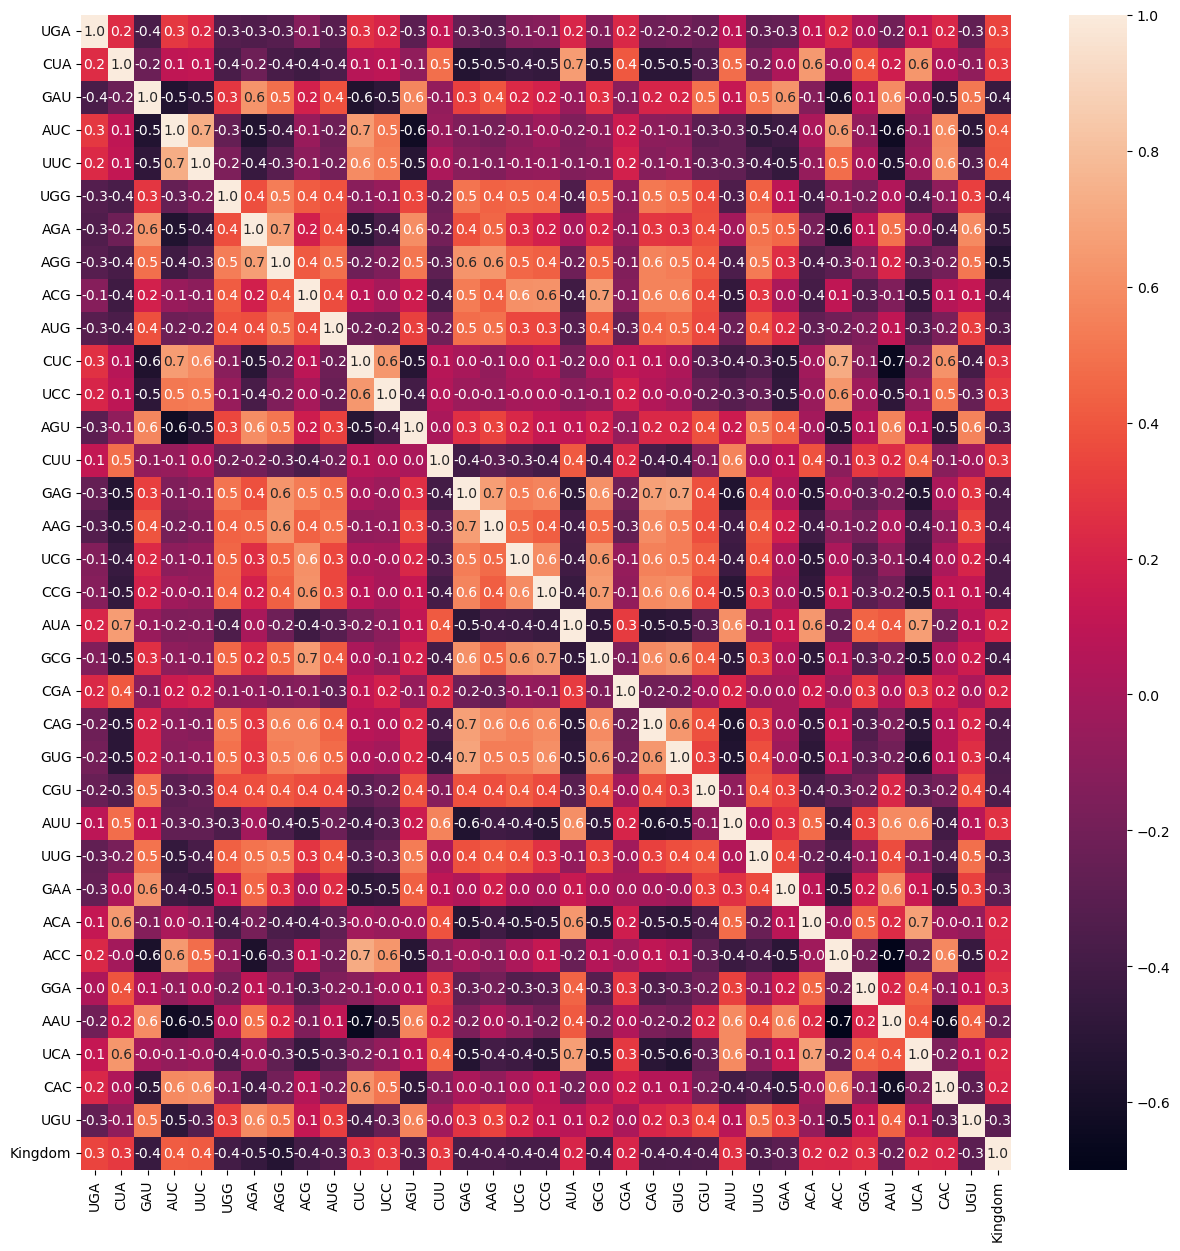

In [49]:
show_heatmap(data, figsize=(15, 15))

array([[<Axes: title={'center': 'UGA'}>, <Axes: title={'center': 'CUA'}>,
        <Axes: title={'center': 'GAU'}>, <Axes: title={'center': 'AUC'}>,
        <Axes: title={'center': 'UUC'}>, <Axes: title={'center': 'UGG'}>],
       [<Axes: title={'center': 'AGA'}>, <Axes: title={'center': 'AGG'}>,
        <Axes: title={'center': 'ACG'}>, <Axes: title={'center': 'AUG'}>,
        <Axes: title={'center': 'CUC'}>, <Axes: title={'center': 'UCC'}>],
       [<Axes: title={'center': 'AGU'}>, <Axes: title={'center': 'CUU'}>,
        <Axes: title={'center': 'GAG'}>, <Axes: title={'center': 'AAG'}>,
        <Axes: title={'center': 'UCG'}>, <Axes: title={'center': 'CCG'}>],
       [<Axes: title={'center': 'AUA'}>, <Axes: title={'center': 'GCG'}>,
        <Axes: title={'center': 'CGA'}>, <Axes: title={'center': 'CAG'}>,
        <Axes: title={'center': 'GUG'}>, <Axes: title={'center': 'CGU'}>],
       [<Axes: title={'center': 'AUU'}>, <Axes: title={'center': 'UUG'}>,
        <Axes: title={'center': 'G

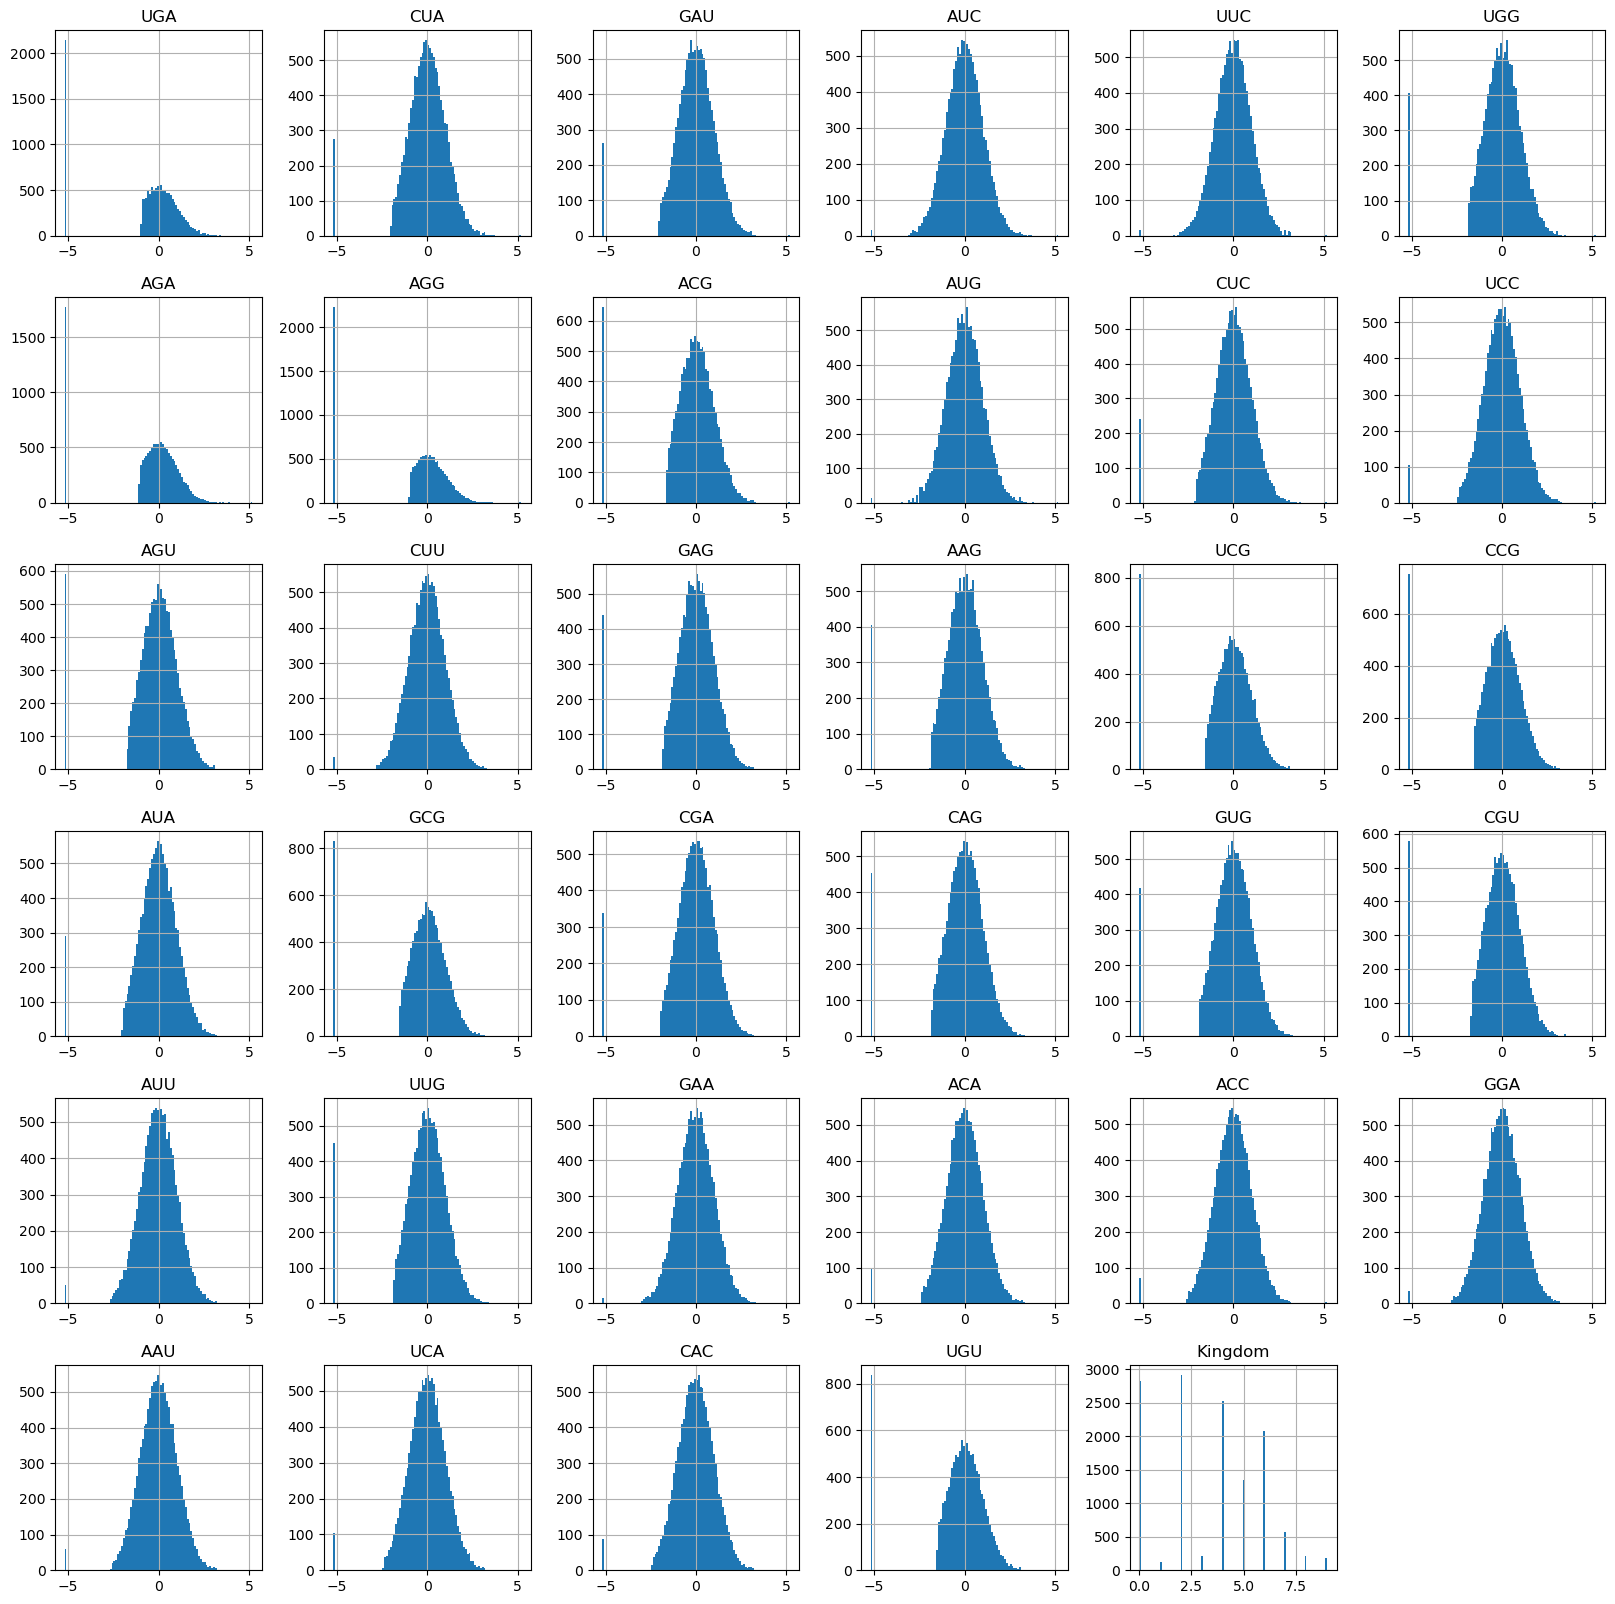

In [50]:
data.hist(figsize=(20, 20), bins = 100)

In [53]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error, mean_squared_log_error, accuracy_score, roc_auc_score, f1_score

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = data.drop(columns = [target_col])
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

model = MLPClassifier(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(accuracy_score(y_test, y_pred))

Iteration 1, loss = 1.51305884
Iteration 2, loss = 0.98300121
Iteration 3, loss = 0.84830350
Iteration 4, loss = 0.77365960
Iteration 5, loss = 0.71788087
Iteration 6, loss = 0.68327064
Iteration 7, loss = 0.65066505
Iteration 8, loss = 0.62610676
Iteration 9, loss = 0.60204350
Iteration 10, loss = 0.58081718
Iteration 11, loss = 0.57118282
Iteration 12, loss = 0.55269482
Iteration 13, loss = 0.53982259
Iteration 14, loss = 0.52946468
Iteration 15, loss = 0.53113854
Iteration 16, loss = 0.51068566
Iteration 17, loss = 0.50560095
Iteration 18, loss = 0.49863154
Iteration 19, loss = 0.48697618
Iteration 20, loss = 0.48941416
Iteration 21, loss = 0.48198000
Iteration 22, loss = 0.47757180
Iteration 23, loss = 0.46811960
Iteration 24, loss = 0.46930421
Iteration 25, loss = 0.48535773
Iteration 26, loss = 0.45279234
Iteration 27, loss = 0.45455949
Iteration 28, loss = 0.44571428
Iteration 29, loss = 0.44509746
Iteration 30, loss = 0.44087738
Iteration 31, loss = 0.43667004
Iteration 32, los

In [54]:
data.to_csv('./data/codon/data_cleaned.csv', index=False)
import json
with open('./data/codon/data_config.json', 'w') as f:
    json.dump(data_config, f)

## School

In [7]:
import scipy.io
from collections import Counter

In [8]:
mat = scipy.io.loadmat('./data/school/school.mat')
# Note that the raw data structure is different from school
raw_x, raw_y = mat['X'][0], mat['Y'][0]  # y is exam score
assert len(raw_x) == len(raw_y)
num_clients = len(raw_x)

print('School dataset:')
print('number of clients:', num_clients, len(raw_y))
print('number of examples:', [len(raw_x[i]) for i in range(num_clients)])
print('number of features:', len(raw_x[0][0]))

raw_x, raw_y = mat['X'][0], mat['Y'][0]
combined_x= np.vstack(raw_x)
combiend_y = np.vstack(raw_y)
data = pd.DataFrame(combined_x, columns = [f'Feature_{i}' for i in range(combined_x.shape[1])])
clients_split_indices = np.cumsum([len(raw_x[i]) for i in range(num_clients-1)])
print(clients_split_indices)
target_col = 'score'
data[target_col] = combiend_y
data

School dataset:
number of clients: 139 139
number of examples: [200, 91, 95, 212, 40, 57, 47, 113, 160, 182, 215, 113, 25, 34, 110, 123, 103, 182, 107, 137, 86, 45, 146, 201, 36, 67, 146, 68, 137, 251, 92, 189, 180, 103, 165, 119, 145, 73, 234, 105, 140, 100, 129, 140, 35, 198, 175, 136, 176, 46, 91, 157, 50, 150, 184, 65, 154, 88, 76, 181, 74, 168, 94, 131, 181, 48, 64, 175, 46, 62, 140, 249, 81, 116, 30, 22, 109, 57, 74, 81, 150, 107, 60, 83, 92, 100, 116, 96, 130, 47, 60, 151, 55, 29, 163, 135, 90, 110, 179, 72, 43, 155, 73, 159, 115, 107, 69, 83, 34, 129, 212, 51, 120, 38, 125, 157, 54, 128, 77, 39, 42, 102, 39, 97, 96, 97, 185, 64, 112, 232, 31, 59, 238, 215, 151, 28, 79, 72, 23]
number of features: 28
[  200   291   386   598   638   695   742   855  1015  1197  1412  1525
  1550  1584  1694  1817  1920  2102  2209  2346  2432  2477  2623  2824
  2860  2927  3073  3141  3278  3529  3621  3810  3990  4093  4258  4377
  4522  4595  4829  4934  5074  5174  5303  5443  5478  5676  58

,Feature_0,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,...,Feature_19,Feature_20,Feature_21,Feature_22,Feature_23,Feature_24,Feature_25,Feature_26,Feature_27,score
0,1,0,0,24,18,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,17
1,1,0,0,24,18,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,5
2,1,0,0,24,18,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,16
3,1,0,0,24,18,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,12
4,1,0,0,24,18,0,1,0,0,1,...,0,0,1,0,0,1,0,0,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15357,0,0,1,38,24,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,8
15358,0,0,1,38,24,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,18
15359,0,0,1,38,24,1,0,0,0,1,...,0,0,0,0,1,1,0,0,1,14
15360,0,0,1,38,24,1,0,0,1,0,...,0,0,0,0,1,1,0,0,1,34


In [18]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.999)

cols = data.columns.tolist()[:-1]
data_pca = pca.fit_transform(data[cols])

data_pca = pd.DataFrame(data_pca, columns = [f'PCA_{i}' for i in range(data_pca.shape[1])])
data_pca[target_col] = data[target_col]
data_pca

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6,PCA_7,PCA_8,PCA_9,PCA_10,PCA_11,score
0,-14.778429,-9.281489,-0.725685,0.158514,-0.701849,0.167937,-0.587682,0.072419,-0.267947,0.044452,-0.194080,0.289524,17
1,-14.778429,-9.281489,-0.725685,0.158514,-0.701849,0.167937,-0.587682,0.072419,-0.267947,0.044452,-0.194080,0.289524,5
2,-14.778429,-9.281489,-0.725685,0.158514,-0.701849,0.167937,-0.587682,0.072419,-0.267947,0.044452,-0.194080,0.289524,16
3,-14.778429,-9.281489,-0.725685,0.158514,-0.701849,0.167937,-0.587682,0.072419,-0.267947,0.044452,-0.194080,0.289524,12
4,-14.778429,-9.281489,-0.725685,0.158514,-0.701849,0.167937,-0.587682,0.072419,-0.267947,0.044452,-0.194080,0.289524,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15357,-3.369950,0.850501,1.014985,-0.773415,-0.218463,-0.826644,0.021783,0.237717,0.284705,-0.200621,0.003749,0.452198,8
15358,-3.375631,0.856205,0.987569,-0.434510,-0.351862,-0.930140,-0.346857,-0.353301,0.209082,0.113723,0.073344,0.116239,18
15359,-3.375631,0.856205,0.987569,-0.434510,-0.351862,-0.930140,-0.346857,-0.353301,0.209082,0.113723,0.073344,0.116239,14
15360,-3.371473,0.862224,0.932291,-0.006634,0.882259,-0.935227,0.061185,0.190200,0.278816,-0.612279,0.015366,0.428955,34


In [66]:
data = data.drop(columns = [
    'Feature_27', 'Feature_11', 'Feature_12', 'Feature_13', 'Feature_14', 'Feature_15', 'Feature_16', 'Feature_17', 
    'Feature_18', 'Feature_19', 'Feature_20', 'Feature_25'
], axis = 1)
print(data.shape)

data.columns = [idx for idx, col in enumerate(data.columns[:-1])] + [target_col] 

(15362, 17)


In [23]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline

# scaling
scaler = Pipeline([
    ('standard', StandardScaler()),
    ('minmax', MinMaxScaler())
])

cols = data_pca.columns.tolist()
cols.remove(target_col)
data_pca[cols] = scaler.fit_transform(data_pca[cols])

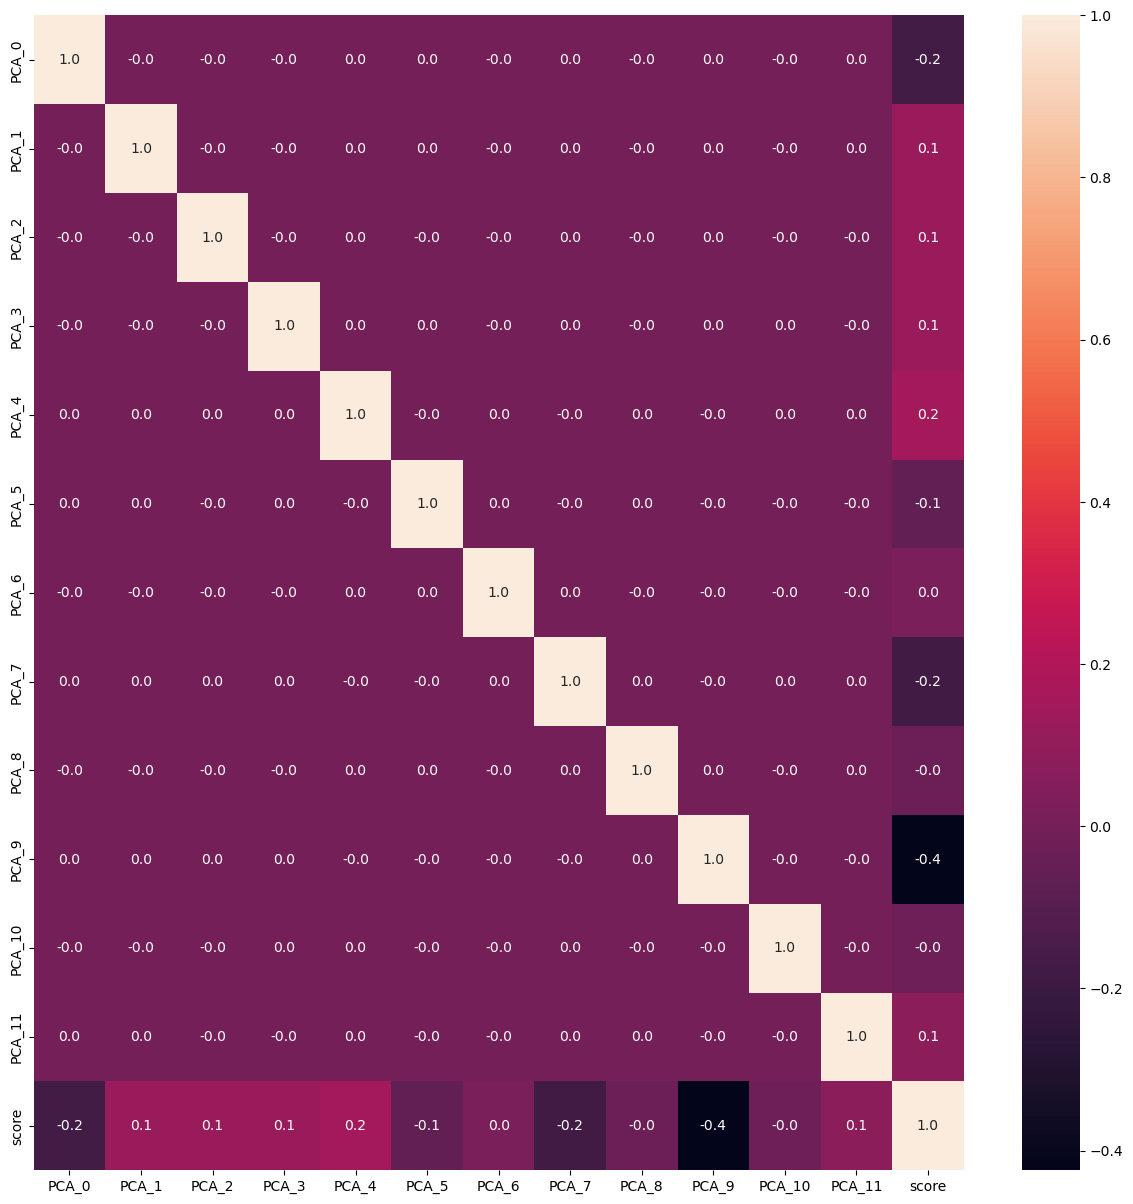

In [24]:
show_heatmap(data_pca, figsize=(15, 15))

In [20]:
avg_correlation(data_pca)

[('PCA_9', 0.10956834738641819),
 ('PCA_7', 0.09038349070856076),
 ('PCA_0', 0.0899530683581429),
 ('PCA_4', 0.08884931684075938),
 ('PCA_1', 0.08661751798955183),
 ('PCA_2', 0.08649796816565228),
 ('PCA_3', 0.08635830931876155),
 ('PCA_11', 0.08251831369344487),
 ('PCA_5', 0.08211802478084854),
 ('PCA_8', 0.07951045665531635),
 ('PCA_10', 0.07870580236946675),
 ('PCA_6', 0.07833950748896751)]

In [22]:
data_pca.corrwith(data_pca[target_col]).abs().sort_values(ascending = False)

score     1.000000
PCA_9     0.424389
PCA_7     0.174985
PCA_0     0.169390
PCA_4     0.155041
PCA_1     0.126028
PCA_2     0.124474
PCA_3     0.122658
PCA_11    0.072738
PCA_5     0.067534
PCA_8     0.033636
PCA_10    0.023175
PCA_6     0.018414
dtype: float64

In [37]:
num_cols = data_pca.columns.tolist()[:-1]
data_config = {
    'target': target_col,
    'features_idx': list(range(len(data_pca.columns)-1)),
    'split_col_idx': [9, 7],
    'ms_col_idx': [idx for idx in range(0, data_pca.shape[1]) if data_pca.columns[idx] in num_cols],
    'obs_col_idx': [6, 10],
    'num_cols': len(num_cols),
    'task_type': 'regression',
    'clf_type': 'none',
    'data_type': 'tabular',
    'client_split_indices': clients_split_indices.tolist()
}
print(data_config)

{'target': 'score', 'features_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'split_col_idx': [9, 7], 'ms_col_idx': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], 'obs_col_idx': [6, 10], 'num_cols': 12, 'task_type': 'regression', 'clf_type': 'none', 'data_type': 'tabular', 'client_split_indices': [200, 291, 386, 598, 638, 695, 742, 855, 1015, 1197, 1412, 1525, 1550, 1584, 1694, 1817, 1920, 2102, 2209, 2346, 2432, 2477, 2623, 2824, 2860, 2927, 3073, 3141, 3278, 3529, 3621, 3810, 3990, 4093, 4258, 4377, 4522, 4595, 4829, 4934, 5074, 5174, 5303, 5443, 5478, 5676, 5851, 5987, 6163, 6209, 6300, 6457, 6507, 6657, 6841, 6906, 7060, 7148, 7224, 7405, 7479, 7647, 7741, 7872, 8053, 8101, 8165, 8340, 8386, 8448, 8588, 8837, 8918, 9034, 9064, 9086, 9195, 9252, 9326, 9407, 9557, 9664, 9724, 9807, 9899, 9999, 10115, 10211, 10341, 10388, 10448, 10599, 10654, 10683, 10846, 10981, 11071, 11181, 11360, 11432, 11475, 11630, 11703, 11862, 11977, 12084, 12153, 12236, 12270, 12399, 12611, 12662, 12782, 12820, 12945

In [39]:
data_pca.shape

(15362, 13)

In [34]:
data_pca[target_col] = data[target_col].astype(float)

In [40]:
data_pca.to_csv('./data/school/data_cleaned_pca.csv', index=False)
import json
with open('./data/school/data_config_pca.json', 'w') as f:
    json.dump(data_config, f)

array([[<Axes: title={'center': 'PCA_0'}>,
        <Axes: title={'center': 'PCA_1'}>,
        <Axes: title={'center': 'PCA_2'}>,
        <Axes: title={'center': 'PCA_3'}>],
       [<Axes: title={'center': 'PCA_4'}>,
        <Axes: title={'center': 'PCA_5'}>,
        <Axes: title={'center': 'PCA_6'}>,
        <Axes: title={'center': 'PCA_7'}>],
       [<Axes: title={'center': 'PCA_8'}>,
        <Axes: title={'center': 'PCA_9'}>,
        <Axes: title={'center': 'PCA_10'}>,
        <Axes: title={'center': 'PCA_11'}>],
       [<Axes: title={'center': 'score'}>, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

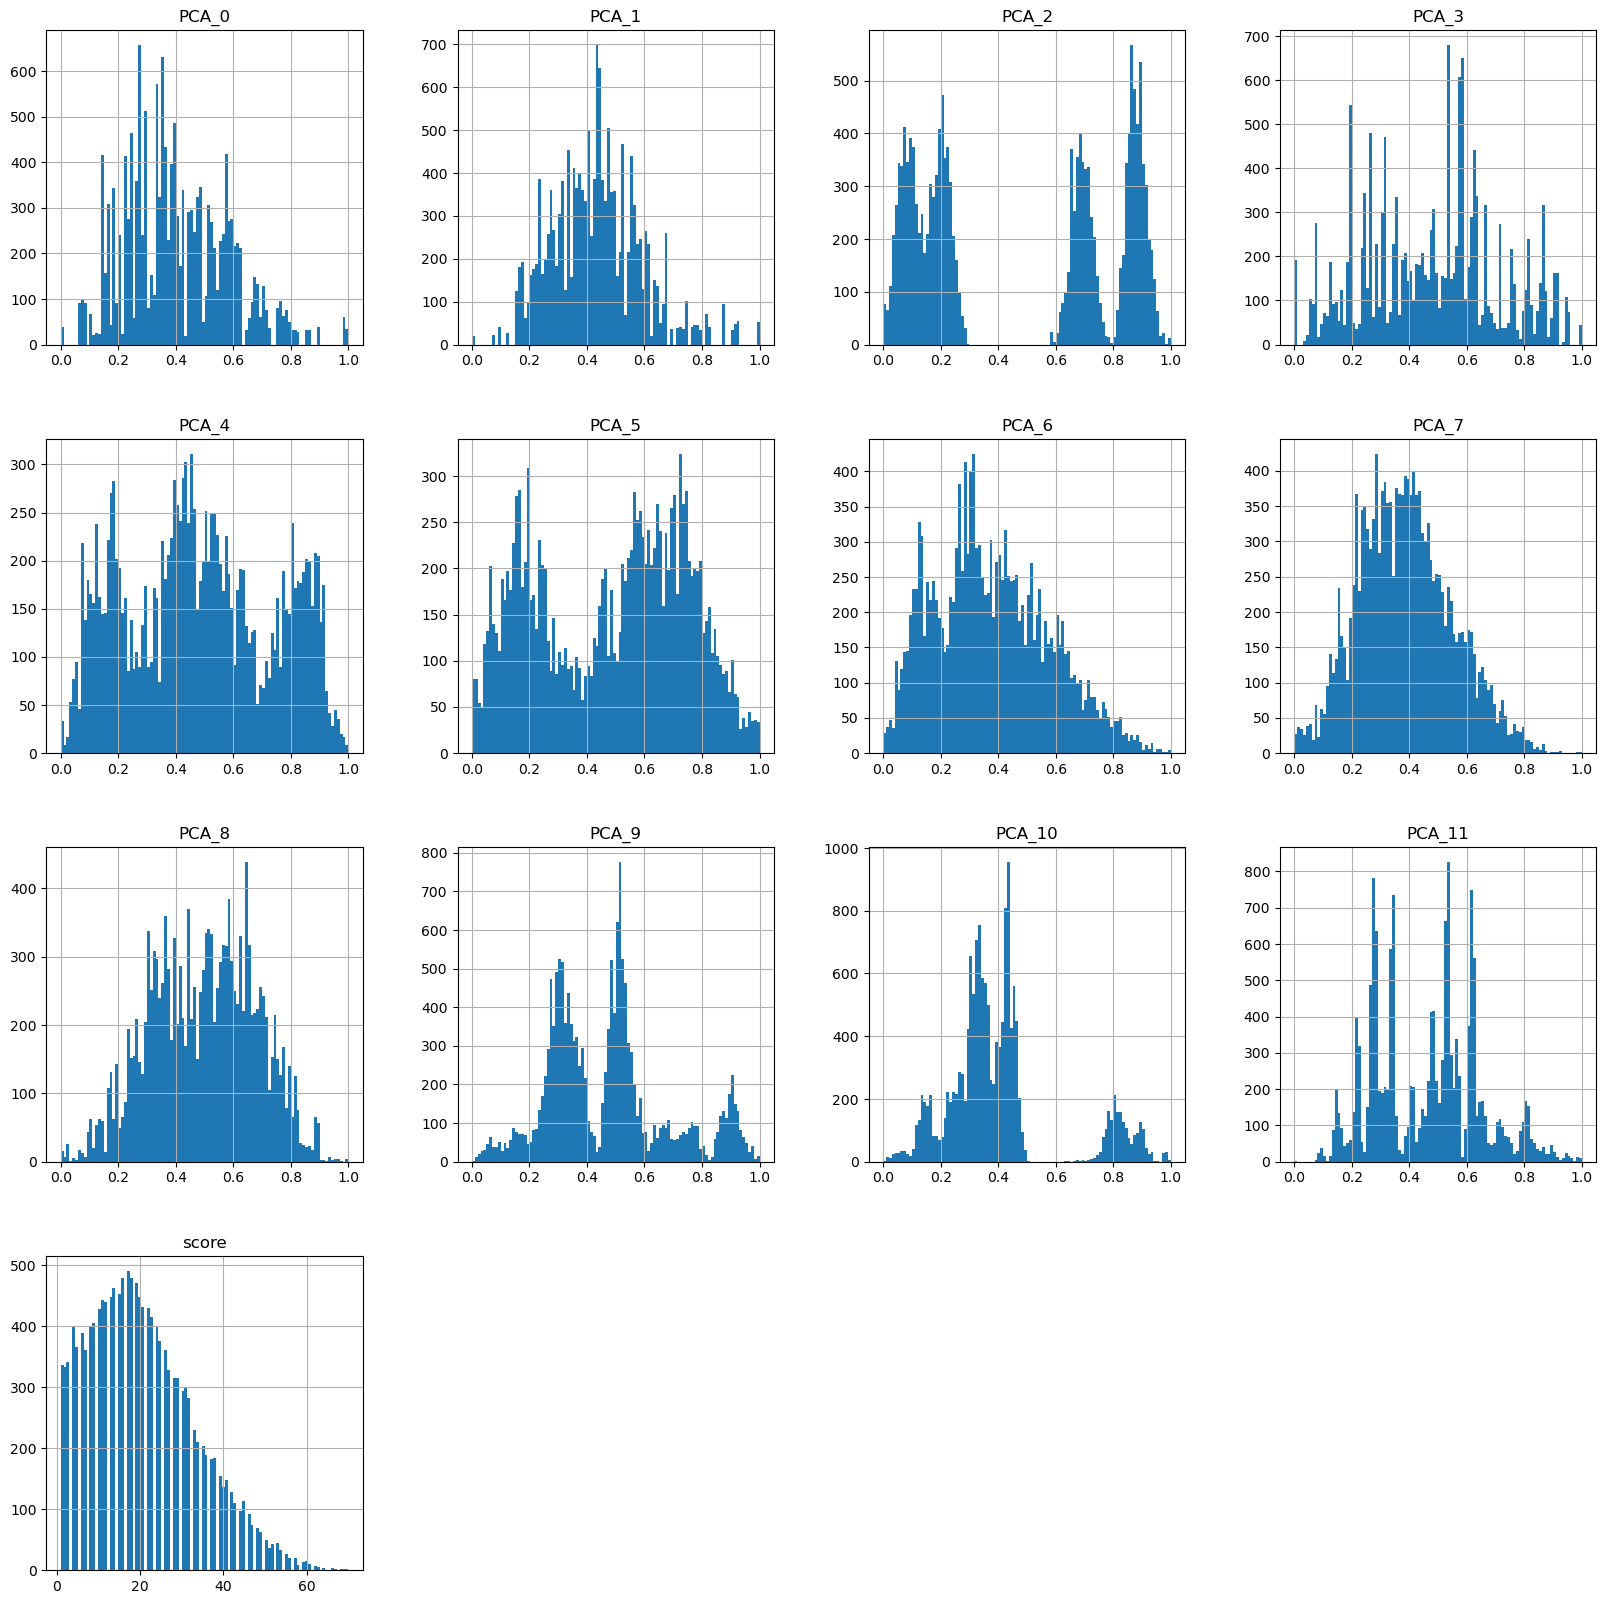

In [29]:
data_pca.hist(figsize=(20, 20), bins = 100)

In [75]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X = data.drop(columns = [target_col])
y = data[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error

model = MLPRegressor(hidden_layer_sizes=(128, 128), max_iter=1000, alpha=0.5, random_state=42, verbose=True)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, y_pred)))

Iteration 1, loss = 155.63793724
Iteration 2, loss = 63.42926435
Iteration 3, loss = 56.55772231
Iteration 4, loss = 55.41621714
Iteration 5, loss = 55.06568449
Iteration 6, loss = 55.15466451
Iteration 7, loss = 54.71580524
Iteration 8, loss = 54.55388021
Iteration 9, loss = 54.55841697
Iteration 10, loss = 54.48780140
Iteration 11, loss = 54.42219977
Iteration 12, loss = 54.29701207
Iteration 13, loss = 54.40742758
Iteration 14, loss = 54.19606329
Iteration 15, loss = 54.31208688
Iteration 16, loss = 54.12192301
Iteration 17, loss = 54.10339308
Iteration 18, loss = 54.19137936
Iteration 19, loss = 54.02293192
Iteration 20, loss = 54.04928848
Iteration 21, loss = 54.08166208
Iteration 22, loss = 53.96387124
Iteration 23, loss = 53.83615499
Iteration 24, loss = 53.82756086
Iteration 25, loss = 53.82223767
Iteration 26, loss = 53.74876319
Iteration 27, loss = 53.78205938
Iteration 28, loss = 53.96951047
Iteration 29, loss = 53.62203938
Iteration 30, loss = 53.62989170
Iteration 31, loss